# Exploring Machine Learning on Quantopian
Recently, Quantopian’s Chief Investment Officer, Jonathan Larkin, shared an industry insider’s overview of the [professional quant equity workflow](http://blog.quantopian.com/a-professional-quant-equity-workflow/). This workflow is comprised of distinct stages including: (1) Universe Definition, (2) Alpha Discovery, (3) Alpha Combination, (4) Portfolio Construction and (5) Trading.

This Notebook focuses on stage 3: Alpha Combination. At this stage, Machine Learning is an intuitive choice as we have abstracted the problem to such a degree that it is now a classic classification (or regression) problem which ML is very good at solving and coming up with an alpha combination that is predictive.

As you will see, there is a lot of code here setting up a factor library and some data wrangling to get everything into shape. The details of this part are perhaps not quite as interesting so feel free to skip directly to ["Training our ML pipeline"](#training) where we have everything in place to train and test our classifier.

## Overview
1. Define trading universe to use ([Q500US and Q1500US](https://www.quantopian.com/posts/the-q500us-and-q1500us)).
2. Define alphas (implemented in [Pipeline](https://www.quantopian.com/tutorials/pipeline)).
3. Run pipeline.
4. Split into train and test set.
5. Preprocess data (rank alphas, subsample, align alphas with future returns, impute, scale).
6. Train Machine Learning classifier ([AdaBoost from Scikit-Learn](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)).
7. Evaluate Machine Learning classifier on test set.

Note that one important limitation is that we only train and test on static (i.e. fixed-in-time) data. Thus, you can not directly do the same in an algorithm. In principle, this is possible and will be the next step but it makes sense to first focus on just the ML in a more direct way to get a good intuition about the workflow and how to develop a competitive ML pipeline.

### Disclaimer
This workflow is still a bit rough around the edges. We are working on improving it and adding better educational materials. This serves as a sneak-peek for the curious and adventurous.

In [1]:
from quantopian.research import run_pipeline
from quantopian.pipeline import Pipeline
from quantopian.pipeline.factors import Latest
from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.pipeline.data import morningstar
from quantopian.pipeline.factors import (
    AnnualizedVolatility,
    Aroon, # not working here
    AverageDollarVolume,
    BollingerBands,
    FastStochasticOscillator,
    MarketCap,
    MovingAverageConvergenceDivergenceSignal,
    TrueRange,
    VWAP,
    WeightedAverageValue,
    CustomFactor,
    SimpleMovingAverage,
    AverageDollarVolume,
    Returns,
    RSI,
    EWMA
        
)
from quantopian.pipeline.classifiers.morningstar import Sector
from quantopian.pipeline.filters import Q500US, Q1500US
from quantopian.pipeline.data.quandl import fred_usdontd156n as libor
from quantopian.pipeline.data.zacks import EarningsSurprises

import talib
import pandas as pd
import numpy as np
from time import time

import alphalens as al
import pyfolio as pf
from scipy import stats
import matplotlib.pyplot as plt
from sklearn import linear_model, decomposition, ensemble, preprocessing, isotonic, metrics

## Definition of some commonly used factors
The factors below are a small collection of commonly used alphas that were coded by Gil Wassermann. I will post a separate Notebook with the full collection and more descriptions of them. Ultimately we will put these into a library you can just import to avoid the wall of text. If you want to understand more about pipeline, read the [tutorial](https://www.quantopian.com/tutorials/pipeline).

Also note the `Earnings_Quality` alpha which uses [Zacks Earnings Surprises](https://www.quantopian.com/data/zacks/earnings_surprises), a [new source from our partners](https://www.quantopian.com/data).

The details of these factors are not the focus of this Notebook so feel free to just [skip](#universe) this cell.

In [2]:
bs = morningstar.balance_sheet
cfs = morningstar.cash_flow_statement
is_ = morningstar.income_statement
or_ = morningstar.operation_ratios
er = morningstar.earnings_report
v = morningstar.valuation
vr = morningstar.valuation_ratios


def make_factors():
    
    
    def Asset_Growth_3M():
        return Returns(inputs=[bs.total_assets], window_length=63)

    def Asset_To_Equity_Ratio():
        return bs.total_assets.latest / bs.common_stock_equity.latest

    def Capex_To_Cashflows():
        return (cfs.capital_expenditure.latest * 4.) / \
            (cfs.free_cash_flow.latest * 4.)
        
    def EBITDA_Yield():
        return (is_.ebitda.latest * 4.) / \
            USEquityPricing.close.latest        

    def EBIT_To_Assets():
        return (is_.ebit.latest * 4.) / \
            bs.total_assets.latest
        
    def Earnings_Quality():
        return morningstar.cash_flow_statement.operating_cash_flow.latest / \
               EarningsSurprises.eps_act.latest
        
    def Return_On_Total_Invest_Capital():
        return or_.roic.latest
   
    class Mean_Reversion_1M(CustomFactor):
        inputs = [Returns(window_length=21)]
        window_length = 252

        def compute(self, today, assets, out, monthly_rets):
            out[:] = (monthly_rets[-1] - np.nanmean(monthly_rets, axis=0)) / \
                np.nanstd(monthly_rets, axis=0)
            
    class Mean_Reversion_2D(CustomFactor):
        inputs = [Returns(window_length=2)]
        window_length = 252

        def compute(self, today, assets, out, monthly_rets):
            out[:] = (monthly_rets[-1] - np.nanmean(monthly_rets, axis=0)) / \
                np.nanstd(monthly_rets, axis=0)
    class Mean_Reversion_5D(CustomFactor):
        inputs = [Returns(window_length=5)]
        window_length = 252

        def compute(self, today, assets, out, monthly_rets):
            out[:] = (monthly_rets[-1] - np.nanmean(monthly_rets, axis=0)) / \
                np.nanstd(monthly_rets, axis=0)
            
    class Mean_Reversion_6D(CustomFactor):
        inputs = [Returns(window_length=6)]
        window_length = 252

        def compute(self, today, assets, out, monthly_rets):
            out[:] = (monthly_rets[-1] - np.nanmean(monthly_rets, axis=0)) / \
                np.nanstd(monthly_rets, axis=0)
                
    class MACD_Signal_10d(CustomFactor):
        inputs = [USEquityPricing.close]
        window_length = 60

        def compute(self, today, assets, out, close):

            sig_lines = []

            for col in close.T:
                # get signal line only
                try:
                    _, signal_line, _ = talib.MACD(col, fastperiod=12,
                                                   slowperiod=26, signalperiod=10)
                    sig_lines.append(signal_line[-1])
                # if error calculating, return NaN
                except:
                    sig_lines.append(np.nan)
            out[:] = sig_lines 
            
    # THESE ARE MY CUSTOM TALIB FACTORS
    
    

    """
    HELPER FUNCTIONS
    """

    def plus_dm_helper(high, low):
        """
        Returns positive directional movement. Abstracted for use with more complex factors

        https://www.fidelity.com/learning-center/trading-investing/technical-analysis/technical-indicator-guide/DMI

        Parameters
        ----------
        high : np.array
            matrix of high prices
        low : np.array
            matrix of low prices

        Returns
        -------
        np.array : matrix of positive directional movement

        """
        # get daily differences between high prices
        high_diff = (high - np.roll(high, 1, axis=0))[1:]

        # get daily differences between low prices
        low_diff = (np.roll(low, 1, axis=0) - low)[1:]

        # matrix of positive directional movement
        return np.where(((high_diff > 0) | (low_diff > 0)) & (high_diff > low_diff), high_diff, 0.)

    def minus_dm_helper(high, low):
        """
        Returns negative directional movement. Abstracted for use with more complex factors

        https://www.fidelity.com/learning-center/trading-investing/technical-analysis/technical-indicator-guide/DMI

        Parameters
        ----------
        high : np.array
            matrix of high prices
        low : np.array
            matrix of low prices

        Returns
        -------
        np.array : matrix of negative directional movement

        """
        # get daily differences between high prices
        high_diff = (high - np.roll(high, 1, axis=0))[1:]

        # get daily differences between low prices
        low_diff = (np.roll(low, 1, axis=0) - low)[1:]

        # matrix of megative directional movement
        return np.where(((high_diff > 0) | (low_diff > 0)) & (high_diff < low_diff), low_diff, 0.)


    def trange_helper(high, low, close):
        """
        Returns true range

        http://www.macroption.com/true-range/

        Parameters
        ----------
        high : np.array
            matrix of high prices
        low : np.array
            matrix of low prices
        close: np.array
            matrix of close prices

        Returns
        -------
        np.array : matrix of true range

        """
        # define matrices to be compared
        close = close[:-1]
        high = high[1:]
        low = low[1:]

        # matrices for comparison
        high_less_close = high - close
        close_less_low = close - low
        high_less_low = high - low

        # return maximum value for each cel
        return np.maximum(high_less_close, close_less_low, high_less_low)


    """
    Techincal Analysis Indicators
    """


    class AD(CustomFactor):
        """
        Chaikin Accumulation Distribution Line

        Volume indicator

        **Default Inputs:** USEquityPricing.high, USEquityPricing.low, USEquitypricing.close, USEquityPricing.volume

        **Default Window Length:** 14

        http://stockcharts.com/school/doku.php?id=chart_school:technical_indicators:accumulation_distribution_line
        """	    
        inputs = [USEquityPricing.close, USEquityPricing.high, USEquityPricing.low, USEquityPricing.volume]
        window_length = 14

        def compute(self, today, assets, out, close, high, low, vol):

            # close location value
            clv = ((close - low) - (high - close)) / (high - low)
            ad = clv * vol
            out[:] =  np.sum(ad, axis=0)


    class ADX(CustomFactor):
        """
        Average Directional Movement Index

        Momentum indicator. Smoothed DX

        **Default Inputs:** USEquityPricing.high, USEquityPricing.low, USEquitypricing.close

        **Default Window Length:** 29

        https://www.fidelity.com/learning-center/trading-investing/technical-analysis/technical-indicator-guide/DMI
        """	    
        inputs = [USEquityPricing.high, USEquityPricing.low, USEquityPricing.close]
        window_length = 29

        def compute(self, today, assets, out, high, low, close):

            # positive directional index
            plus_di = 100 * np.cumsum(plus_dm_helper(high, low) / trange_helper(high, low, close), axis=0)

            # negative directional index
            minus_di = 100 * np.cumsum(minus_dm_helper(high, low) / trange_helper(high, low, close), axis=0)

            # full dx with 15 day burn-in period
            dx_frame = (np.abs(plus_di - minus_di) / (plus_di + minus_di) * 100.)[14:]

            # 14-day EMA
            span = 14.
            decay_rate = 2. / (span + 1.)
            weights = weights_long = np.full(span, decay_rate, float) ** np.arange(span + 1, 1, -1)

            # return EMA
            out[:] = np.average(dx_frame, axis=0, weights=weights)


    def APO(shortperiod=12, longperiod=26):
        """
        Absolute Price Oscillator

        Momentum indeicator. Difference between EWMAs (exponential weighted moving averages) of 
        short and long periods.

        **Default Inputs:** 12, 26

        **Default Window Length:** 46 (26 + 20-day burn-in)

        https://www.fidelity.com/learning-center/trading-investing/technical-analysis/technical-indicator-guide/apo

        Parameters
        ----------
        shortperiod : int > 0
            window length for short EWMA
        longperiod : int > 0 (>= shortperiod)
            window length for longer EWMA

        Returns
        -------
        zipline.Factor
        """
        buffer_window = longperiod + 20

        fast = EWMA.from_span(inputs=[USEquityPricing.close], window_length=buffer_window, span=shortperiod)
        slow = EWMA.from_span(inputs=[USEquityPricing.close], window_length=buffer_window, span=longperiod) 
        return fast - slow


    class ATR(CustomFactor):
        """
        Average True Range

        Momentum indicator

        **Default Inputs:** USEquityPricing.high, USEquityPricing.low, USEquityPricing.close

        **Default Window Length:** 15 (14+1)

        https://en.wikipedia.org/wiki/Average_true_range
        """
        inputs=[USEquityPricing.high, USEquityPricing.low, USEquityPricing.close]
        window_length = 15

        def compute(self, today, assets, out, high, low, close):

            tr_frame = trange_helper(high, low, close)
            decay_rate= 2./(len(tr_frame) + 1.)
            weights = np.full(len(tr_frame), decay_rate, float) ** np.arange(len(tr_frame) + 1, 1, -1)
            out[:] = np.average(tr_frame, axis=0, weights=weights)


    class BETA(CustomFactor):
        """
        Market Beta (returns)

        **Default Inputs:** USEquityPricing.close

        **Default Window Length:** 6

        https://en.wikipedia.org/wiki/Beta_(finance)
        """

        inputs=[USEquityPricing.close]
        window_length = 6

        def compute(self, today, assets, out, close):

            # get returns dataset
            returns = ((close - np.roll(close, 1, axis=0)) / np.roll(close, 1, axis=0))[1:]

            # get index of benchmark
            benchmark_index = np.where((assets == 8554) == True)[0][0]

            # get returns of benchmark
            benchmark_returns = returns[:, benchmark_index]

            # prepare X matrix (x_is - x_bar)
            X = benchmark_returns
            X_bar = np.nanmean(X)
            X_vector = X - X_bar
            X_matrix = np.tile(X_vector, (len(returns.T), 1)).T

            # prepare Y matrix (y_is - y_bar)
            Y_bar = np.nanmean(close, axis=0)
            Y_bars = np.tile(Y_bar, (len(returns), 1))
            Y_matrix = returns - Y_bars

            # prepare variance of X
            X_var = np.nanvar(X)

            # multiply X matrix an Y matrix and sum (dot product)
            # then divide by variance of X
            # this gives the MLE of Beta
            out[:] = (np.sum((X_matrix * Y_matrix), axis=0) / X_var) / (len(returns))


    class BOP(CustomFactor):
        """
        Balance of Power

        Momentum indicator

        **Default Inputs:** USEquityPricing.close, USEquityPricing.open, USEquityPricing.high, USEquityPricing.low

        **Default Window Length:** 1

        https://www.interactivebrokers.com/en/software/tws/usersguidebook/technicalanalytics/balancepower.htm
        """
        inputs = [USEquityPricing.close, USEquityPricing.open, USEquityPricing.high, USEquityPricing.low]
        window_length = 1

        def compute(self, today, assets, out, close, open, high, low):
            out[:] = (close - open) / (high - low)
    



    class CCI(CustomFactor):
        """
        Commodity Channel Index

        Momentum indicator

        **Default Inputs:** USEquityPricing.close, USEquityPricing.high, USEquityPricing.low

        **Default Window Length:** 14

        http://stockcharts.com/school/doku.php?id=chart_school:technical_indicators:commodity_channel_index_cci
        """

        inputs = [USEquityPricing.high, USEquityPricing.low, USEquityPricing.close]
        window_length = 14

        def compute(self, today, assets, out, high, low, close):

            # typical price matrix
            typical_prices = (high + low + close) / 3.

            # mean of each column
            mean_typical = np.nanmean(typical_prices, axis=0)

            # mean deviation
            mean_deviation = np.sum(np.abs(typical_prices - np.tile(mean_typical, (len(typical_prices), 1))), axis=0) / self.window_length

            # CCI
            out[:] = (typical_prices[-1] - mean_typical) / (.015 * mean_deviation)

   
    class CMO(CustomFactor):
        """
        Chande Momentum Oscillator

        Momentum indicator. Descriptor of overought/oversold conditions

        **Default Inputs:** USEquityPricing.close

        **Default Window Length:** 15 (14 + 1-day for differences)

        https://www.fidelity.com/learning-center/trading-investing/technical-analysis/technical-indicator-guide/cmo
        """
        inputs=[USEquityPricing.close]
        window_length = 15

        def compute(self, today, assets, out, close):

            # daily differences in close prices
            close_diff = (close - np.roll(close, 1, axis=0))[1:]

            # close differences on up days
            su = np.sum(np.where(close_diff > 0, close_diff, 0), axis=0)

            # absolute value of close differences on down days
            sd = np.abs(np.sum(np.where(close_diff < 0, close_diff, 0), axis=0))

            # CMO
            out[:] = 100 * (su - sd) / (su + sd)
    class CMO5D(CustomFactor):
        """
        Chande Momentum Oscillator

        Momentum indicator. Descriptor of overought/oversold conditions

        **Default Inputs:** USEquityPricing.close

        **Default Window Length:** 15 (14 + 1-day for differences)

        https://www.fidelity.com/learning-center/trading-investing/technical-analysis/technical-indicator-guide/cmo
        """
        inputs=[USEquityPricing.close]
        window_length = 5

        def compute(self, today, assets, out, close):

            # daily differences in close prices
            close_diff = (close - np.roll(close, 1, axis=0))[1:]

            # close differences on up days
            su = np.sum(np.where(close_diff > 0, close_diff, 0), axis=0)

            # absolute value of close differences on down days
            sd = np.abs(np.sum(np.where(close_diff < 0, close_diff, 0), axis=0))

            # CMO
            out[:] = 100 * (su - sd) / (su + sd)

    class CMO2D(CustomFactor):
        """
        Chande Momentum Oscillator

        Momentum indicator. Descriptor of overought/oversold conditions

        **Default Inputs:** USEquityPricing.close

        **Default Window Length:** 15 (14 + 1-day for differences)

        https://www.fidelity.com/learning-center/trading-investing/technical-analysis/technical-indicator-guide/cmo
        """
        inputs=[USEquityPricing.close]
        window_length = 2

        def compute(self, today, assets, out, close):

            # daily differences in close prices
            close_diff = (close - np.roll(close, 1, axis=0))[1:]

            # close differences on up days
            su = np.sum(np.where(close_diff > 0, close_diff, 0), axis=0)

            # absolute value of close differences on down days
            sd = np.abs(np.sum(np.where(close_diff < 0, close_diff, 0), axis=0))

            # CMO
            out[:] = 100 * (su - sd) / (su + sd)
        

    class CMO22D(CustomFactor):
        """
        Chande Momentum Oscillator

        Momentum indicator. Descriptor of overought/oversold conditions

        **Default Inputs:** USEquityPricing.close

        **Default Window Length:** 15 (14 + 1-day for differences)

        https://www.fidelity.com/learning-center/trading-investing/technical-analysis/technical-indicator-guide/cmo
        """
        inputs=[USEquityPricing.close]
        window_length = 22

        def compute(self, today, assets, out, close):

            # daily differences in close prices
            close_diff = (close - np.roll(close, 1, axis=0))[1:]

            # close differences on up days
            su = np.sum(np.where(close_diff > 0, close_diff, 0), axis=0)

            # absolute value of close differences on down days
            sd = np.abs(np.sum(np.where(close_diff < 0, close_diff, 0), axis=0))

            # CMO
            out[:] = 100 * (su - sd) / (su + sd)
    class DX(CustomFactor):
        """
        Directional Movement Index

        Momentum indicator

        **Default Inputs:** USEquityPricing.high, USEquityPricing.low, USEquitypricing.close

        **Default Window Length:** 15

        https://www.fidelity.com/learning-center/trading-investing/technical-analysis/technical-indicator-guide/DMI
        """	    
        inputs = [USEquityPricing.high, USEquityPricing.low, USEquityPricing.close]
        window_length = 15

        def compute(self, today, assets, out, high, low, close):

            # positive directional index
            plus_di = 100 * np.sum(plus_dm_helper(high, low) / (trange_helper(high, low, close)), axis=0)

            # negative directional index
            minus_di = 100 * np.sum(minus_dm_helper(high, low) / (trange_helper(high, low, close)), axis=0)

            # DX
            out[:] = np.abs(plus_di - minus_di) / (plus_di + minus_di) * 100.


    class LINEARREG_SLOPE(CustomFactor):
        """
        Slope of Trendline

        Momentum indicator.

        **Default Inputs:**  USEquitypricing.close

        **Default Window Length:** 14

        http://www.stat.cmu.edu/~cshalizi/mreg/15/lectures/06/lecture-06.pdf
        """	    
        inputs=[USEquityPricing.close]
        window_length=14

        # using MLE for speed
        def compute(self, today, assets, out, close):

            # prepare X matrix (x_is - x_bar)
            X = range(self.window_length)
            X_bar = np.nanmean(X)
            X_vector = X - X_bar
            X_matrix = np.tile(X_vector, (len(close.T), 1)).T

            # prepare Y matrix (y_is - y_bar)
            Y_bar = np.nanmean(close, axis=0)
            Y_bars = np.tile(Y_bar, (self.window_length, 1))
            Y_matrix = close - Y_bars

            # prepare variance of X
            X_var = np.nanvar(X)

            # multiply X matrix an Y matrix and sum (dot product)
            # then divide by variance of X
            # this gives the MLE of Beta
            out[:] = (np.sum((X_matrix * Y_matrix), axis=0) / X_var) / (self.window_length)


    class LINEARREG_INTERCEPT(CustomFactor):
        """
        Intercept of Trendline

        **Default Inputs:**  USEquitypricing.close

        **Default Window Length:** 14

        http://www.stat.cmu.edu/~cshalizi/mreg/15/lectures/06/lecture-06.pdf
        """
        inputs=[USEquityPricing.close]
        window_length=14

        # using MLE
        def compute(self, today, assets, out, close):

            # prepare X matrix (x_is - x_bar)
            X = range(self.window_length)
            X_bar = np.nanmean(X)
            X_vector = X - X_bar
            X_matrix = np.tile(X_vector, (len(close.T), 1)).T

            # prepare Y vectors (y_is - y_bar)
            Y_bar = np.nanmean(close, axis=0)
            Y_bars = np.tile(Y_bar, (self.window_length, 1))
            Y_matrix = close - Y_bars

            # prepare variance of X
            X_var = np.nanvar(X)

            # multiply X matrix an Y matrix and sum (dot product)
            # then divide by variance of X
            # this gives the MLE of Beta
            betas = (np.sum((X_matrix * Y_matrix), axis=0) / X_var) / (self.window_length)

            # now use to get to MLE of alpha
            out[:] = Y_bar - (betas * X_bar)


    class MAX(CustomFactor):
        """
        Maximum value for each column of a dataset

        **Default Inputs:**  None

        **Default Window Length:** None
        """
        def compute(self, today, assets, out, data):
            # get vector of maximums
            out[:] = np.nanmax(data, axis=0)


    class MAXINDEX(CustomFactor):
        """
        Index of maximum value for each column of a dataset

        **Default Inputs:**  None

        **Default Window Length:** None
        """
        def compute(self, today, assets, out, data):
            # get vector of indices
            out[:] = np.argmax(data, axis=0)


    class MEDPRICE(CustomFactor):
        """
        Mean of a day's high and low prices

        **Default Inputs:**  USEquityPricing.high, USEquityPricing.low

        **Default Window Length:** 1

        http://www.fmlabs.com/reference/default.htm?url=MedianPrices.htm
        """	    
        inputs = [USEquityPricing.high, USEquityPricing.low]
        window_length = 1

        def compute(self, today, assets, out, high, low):
            out[:] = (high + low) / 2.


    class MFI(CustomFactor):
        """
        Money Flow Index

        Volume Indicator

        **Default Inputs:**  USEquityPricing.high, USEquityPricing.low, USEquityPricing.close, USEquityPricing.volume

        **Default Window Length:** 15 (14 + 1-day for difference in prices)

        http://www.fmlabs.com/reference/default.htm?url=MoneyFlowIndex.htm
        """	    

        inputs = [USEquityPricing.high, USEquityPricing.low, USEquityPricing.close, USEquityPricing.volume]
        window_length = 15

        def compute(self, today, assets, out, high, low, close, vol):

            # calculate typical price
            typical_price = (high + low + close) / 3.

            # calculate money flow of typical price
            money_flow = typical_price * vol

            # get differences in daily typical prices
            tprice_diff = (typical_price - np.roll(typical_price, 1, axis=0))[1:]

            # create masked arrays for positive and negative money flow
            pos_money_flow = np.ma.masked_array(money_flow[1:], tprice_diff < 0, fill_value = 0.)
            neg_money_flow = np.ma.masked_array(money_flow[1:], tprice_diff > 0, fill_value = 0.)

            # calculate money ratio
            money_ratio = np.sum(pos_money_flow, axis=0) / np.sum(neg_money_flow, axis=0)

            # MFI
            out[:] = 100. - (100. / (1. + money_ratio))


    class MIDPOINT(CustomFactor):
        """
        Average of maximum and minimum column values in a dataset

        **Default Inputs:**  None

        **Default Window Length:** None
        """
        def compute(self, today, assets, out, data):
            out[:] = (np.nanmax(data, axis=0) + np.nanmin(data, axis=0)) / 2.


    class MIN(CustomFactor):
        """
        Minimum column values in a dataset

        **Default Inputs:**  None

        **Default Window Length:** None
        """
        def compute(self, today, assets, out, data):
            out[:] = np.nanmin(data, axis=0)


    class MININDEX(CustomFactor):
        """
        Index of minimum column values in a dataset

        **Default Inputs:**  None

        **Default Window Length:** None
        """
        def compute(self, today, assets, out, data):
            out[:] = np.argmin(data, axis=0)


    class MINUS_DI(CustomFactor):
        """
        Negative directional indicator

        Momentum indicator

        **Default Inputs:** USEquityPricing.high, USEquityPricing.low, USEquityPricing.close

        **Default Window Length:** 15

        https://www.fidelity.com/learning-center/trading-investing/technical-analysis/technical-indicator-guide/DMI
        """	

        inputs = [USEquityPricing.high, USEquityPricing.low, USEquityPricing.close]
        window_length = 15

        def compute(self, today, assets, out, high, low, close):
                out[:] = 100 * np.sum(minus_dm_helper(high, low), axis=0) / np.sum(trange_helper(high, low, close), axis=0)


    class MINUS_DM(CustomFactor):
        """
        Negative directional movement

        Momentum indicator

        **Default Inputs:** USEquityPricing.high, USEquityPricing.low

        **Default Window Length:** 15

        https://www.fidelity.com/learning-center/trading-investing/technical-analysis/technical-indicator-guide/DMI
        """	

        inputs = [USEquityPricing.high, USEquityPricing.low]
        window_length = 15

        def compute(self, today, assets, out, high, low):
                out[:] = np.sum(minus_dm_helper(high, low), axis=0)


    class PLUS_DI(CustomFactor):
        """
        Positive directional indicator

        Momentum indicator

        **Default Inputs:** USEquityPricing.high, USEquityPricing.low, USEquityPricing.close

        **Default Window Length:** 15

        https://www.fidelity.com/learning-center/trading-investing/technical-analysis/technical-indicator-guide/DMI
        """	
        inputs = [USEquityPricing.high, USEquityPricing.low, USEquityPricing.close]
        window_length = 15

        def compute(self, today, assets, out, high, low, close):
                out[:] = 100 * np.sum(plus_dm_helper(high, low), axis=0) / np.sum(trange_helper(high, low, close), axis=0)


    class PLUS_DM(CustomFactor):
        """
        Positive directional movement

        Momentum indicator

        **Default Inputs:** USEquityPricing.high, USEquityPricing.low

        **Default Window Length:** 15

        https://www.fidelity.com/learning-center/trading-investing/technical-analysis/technical-indicator-guide/DMI
        """	
        inputs = [USEquityPricing.high, USEquityPricing.low]
        window_length = 15

        def compute(self, today, assets, out, high, low):
                out[:] = np.sum(plus_dm_helper(high, low), axis=0)


    def PPO(fast_period=12, slow_period=26):
        """
        Function to produce CustomFactor of Percentage Price Oscillator
        Called in same way as a normal class, but used in order to give variable
        fast- and slow- periods

        Parameters
        ----------
        fast_period : int > 0
            shorter period moving average 
        slow_period : int > 0 (> fast_period)
            longer period moving average

        Returns
        -------
        zipline.CustomFactor : Percentage Price Oscillator factor

        **Default Inputs:**  12, 26

        http://www.investopedia.com/terms/p/ppo.asp
        """  
        class PPO_(CustomFactor):

            inputs=[USEquityPricing.close]
            window_length = slow_period

            def compute(self, today, assets, out, close):
                slowMA = np.mean(close, axis=0)
                fastMA = np.mean(close[-fast_period:], axis=0)
                out[:] = ((fastMA - slowMA) / slowMA) * 100.

        return PPO_()
    def PPO8_13(fast_period=8, slow_period=13):
        """
        Function to produce CustomFactor of Percentage Price Oscillator
        Called in same way as a normal class, but used in order to give variable
        fast- and slow- periods

        Parameters
        ----------
        fast_period : int > 0
            shorter period moving average 
        slow_period : int > 0 (> fast_period)
            longer period moving average

        Returns
        -------
        zipline.CustomFactor : Percentage Price Oscillator factor

        **Default Inputs:**  12, 26

        http://www.investopedia.com/terms/p/ppo.asp
        """  
        class PPO_(CustomFactor):

            inputs=[USEquityPricing.close]
            window_length = slow_period

            def compute(self, today, assets, out, close):
                slowMA = np.mean(close, axis=0)
                fastMA = np.mean(close[-fast_period:], axis=0)
                out[:] = ((fastMA - slowMA) / slowMA) * 100.

        return PPO_()
    def PPO1_3(fast_period=1, slow_period=3):
        """
        Function to produce CustomFactor of Percentage Price Oscillator
        Called in same way as a normal class, but used in order to give variable
        fast- and slow- periods

        Parameters
        ----------
        fast_period : int > 0
            shorter period moving average 
        slow_period : int > 0 (> fast_period)
            longer period moving average

        Returns
        -------
        zipline.CustomFactor : Percentage Price Oscillator factor

        **Default Inputs:**  12, 26

        http://www.investopedia.com/terms/p/ppo.asp
        """  
        class PPO_(CustomFactor):

            inputs=[USEquityPricing.close]
            window_length = slow_period

            def compute(self, today, assets, out, close):
                slowMA = np.mean(close, axis=0)
                fastMA = np.mean(close[-fast_period:], axis=0)
                out[:] = ((fastMA - slowMA) / slowMA) * 100.

        return PPO_()
    def PPO24_50(fast_period=24, slow_period=50):
        """
        Function to produce CustomFactor of Percentage Price Oscillator
        Called in same way as a normal class, but used in order to give variable
        fast- and slow- periods

        Parameters
        ----------
        fast_period : int > 0
            shorter period moving average 
        slow_period : int > 0 (> fast_period)
            longer period moving average

        Returns
        -------
        zipline.CustomFactor : Percentage Price Oscillator factor

        **Default Inputs:**  12, 26

        http://www.investopedia.com/terms/p/ppo.asp
        """  
        class PPO_(CustomFactor):

            inputs=[USEquityPricing.close]
            window_length = slow_period

            def compute(self, today, assets, out, close):
                slowMA = np.mean(close, axis=0)
                fastMA = np.mean(close[-fast_period:], axis=0)
                out[:] = ((fastMA - slowMA) / slowMA) * 100.

        return PPO_()


    class STDDEV(CustomFactor):
        """
        Standard Deviations of columns in a dataset

        **Default Inputs:**  None

        **Default Window Length:** None
        """
        def compute(self, today, assets, out, data):
            out[:] = np.nanstd(data, axis=0)


    class TRANGE(CustomFactor):
        """
        True Range 

        **Default Inputs:**  USEquityPricing.high, USEquityPricing.low, USEquityPricing.close

        **Default Window Length:** 2

        https://www.fidelity.com/learning-center/trading-investing/technical-analysis/technical-indicator-guide/atr
        """    
        inputs = [USEquityPricing.high, USEquityPricing.low, USEquityPricing.close]
        window_length = 2

        def compute(self, today, assets, out, high, low, close):
            out[:] = np.nanmax([(high[-1] - close[0]), (close[0] - low[-1]), (high[-1] - low[-1])], axis=0)


    class TYPPRICE(CustomFactor):
        """
        Typical Price 

        **Default Inputs:**  USEquityPricing.high, USEquityPricing.low, USEquityPricing.close

        **Default Window Length:** 1

        https://www.fidelity.com/learning-center/trading-investing/technical-analysis/technical-indicator-guide/typical-price
        """    
        inputs = [USEquityPricing.high, USEquityPricing.low, USEquityPricing.close]
        window_length = 1

        def compute(self, today, assets, out, high, low, close):
            out[:] = (high + low + close) / 3.


    class VAR(CustomFactor):
        """
        Variances of columns in a dataset

        **Default Inputs:**  None

        **Default Window Length:** None
        """
        def compute(self, today, assets, out, data):
            out[:] = np.nanvar(data, axis=0)


    class WILLR(CustomFactor):
        """
        Williams %R

        **Default Inputs:**  USEquityPricing.high, USEquityPricing.low, USEquityPricing.close

        **Default Window Length:** 14

        http://www.fmlabs.com/reference/default.htm?url=WilliamsR.htm
        """    	    
        inputs = [USEquityPricing.high, USEquityPricing.low, USEquityPricing.close]
        window_length = 14

        def compute(self, today, assets, out, high, low, close):
            out[:] = (np.nanmax(high, axis=0) - close[-1]) / (np.nanmax(high, axis=0) - np.nanmin(low, axis=0)) * -100.


    class WILLR1(CustomFactor):
        """
        Williams %R

        **Default Inputs:**  USEquityPricing.high, USEquityPricing.low, USEquityPricing.close

        **Default Window Length:** 14

        http://www.fmlabs.com/reference/default.htm?url=WilliamsR.htm
        """    	    
        inputs = [USEquityPricing.high, USEquityPricing.low, USEquityPricing.close]
        window_length = 1

        def compute(self, today, assets, out, high, low, close):
            out[:] = (np.nanmax(high, axis=0) - close[-1]) / (np.nanmax(high, axis=0) - np.nanmin(low, axis=0)) * -100.
    class WILLR2(CustomFactor):
        """
        Williams %R

        **Default Inputs:**  USEquityPricing.high, USEquityPricing.low, USEquityPricing.close

        **Default Window Length:** 14

        http://www.fmlabs.com/reference/default.htm?url=WilliamsR.htm
        """    	    
        inputs = [USEquityPricing.high, USEquityPricing.low, USEquityPricing.close]
        window_length = 2

        def compute(self, today, assets, out, high, low, close):
            out[:] = (np.nanmax(high, axis=0) - close[-1]) / (np.nanmax(high, axis=0) - np.nanmin(low, axis=0)) * -100.
    class WILLR5(CustomFactor):
        """
        Williams %R

        **Default Inputs:**  USEquityPricing.high, USEquityPricing.low, USEquityPricing.close

        **Default Window Length:** 14

        http://www.fmlabs.com/reference/default.htm?url=WilliamsR.htm
        """    	    
        inputs = [USEquityPricing.high, USEquityPricing.low, USEquityPricing.close]
        window_length = 5

        def compute(self, today, assets, out, high, low, close):
            out[:] = (np.nanmax(high, axis=0) - close[-1]) / (np.nanmax(high, axis=0) - np.nanmin(low, axis=0)) * -100.
    class WILLR22(CustomFactor):
        """
        Williams %R

        **Default Inputs:**  USEquityPricing.high, USEquityPricing.low, USEquityPricing.close

        **Default Window Length:** 14

        http://www.fmlabs.com/reference/default.htm?url=WilliamsR.htm
        """    	    
        inputs = [USEquityPricing.high, USEquityPricing.low, USEquityPricing.close]
        window_length = 22

        def compute(self, today, assets, out, high, low, close):
            out[:] = (np.nanmax(high, axis=0) - close[-1]) / (np.nanmax(high, axis=0) - np.nanmin(low, axis=0)) * -100.


    
    
    
    
    class RSI_10d(CustomFactor):
        inputs = [USEquityPricing.close]
        window_length = 60

        def compute(self, today, assets, out, close):

            sig_lines = []

            for col in close.T:
                # get signal line only
                try:
                    signal_line = talib.RSI(col, timeperiod = 10)
                    sig_lines.append(signal_line[-1])
                # if error calculating, return NaN
                except:
                    sig_lines.append(np.nan)
            out[:] = sig_lines
    
    # THESE ARE MY CUSTOM TALIB FACTORS
            
    class Moneyflow_Volume_5d(CustomFactor):
        inputs = [USEquityPricing.close, USEquityPricing.volume]
        window_length = 5

        def compute(self, today, assets, out, close, volume):

            mfvs = []

            for col_c, col_v in zip(close.T, volume.T):

                # denominator
                denominator = np.dot(col_c, col_v)

                # numerator
                numerator = 0.
                for n, price in enumerate(col_c.tolist()):
                    if price > col_c[n - 1]:
                        numerator += price * col_v[n]
                    else:
                        numerator -= price * col_v[n]

                mfvs.append(numerator / denominator)
            out[:] = mfvs  
            
           
    def Net_Income_Margin():
        return or_.net_margin.latest           

    def Operating_Cashflows_To_Assets():
        return (cfs.operating_cash_flow.latest * 4.) / \
            bs.total_assets.latest

    def Price_Momentum_3M():
        return Returns(window_length=63)
    
    class Price_Oscillator(CustomFactor):
        inputs = [USEquityPricing.close]
        window_length = 252

        def compute(self, today, assets, out, close):
            four_week_period = close[-20:]
            out[:] = (np.nanmean(four_week_period, axis=0) /
                      np.nanmean(close, axis=0)) - 1.
    
    
    #mamalol3
    def Returns_39W():
        return Returns(window_length=215)
    
    
    def Returns_39W_190():
        return Returns(window_length=190)
    
    def Returns_39W_160():
        return Returns(window_length=160)
    
    
    
    def Returns_39W_100():
        return Returns(window_length=100)
    
    
    def Returns_39W_50():
        return Returns(window_length=50)
    
    
    
    def Returns_39W_25():
        return Returns(window_length=25)
    
    
    
    class Trendline(CustomFactor):
        inputs = [USEquityPricing.close]
        window_length = 252

        # using MLE for speed
        def compute(self, today, assets, out, close):

            # prepare X matrix (x_is - x_bar)
            X = range(self.window_length)
            X_bar = np.nanmean(X)
            X_vector = X - X_bar
            X_matrix = np.tile(X_vector, (len(close.T), 1)).T

            # prepare Y matrix (y_is - y_bar)
            Y_bar = np.nanmean(close, axis=0)
            Y_bars = np.tile(Y_bar, (self.window_length, 1))
            Y_matrix = close - Y_bars

            # prepare variance of X
            X_var = np.nanvar(X)

            # multiply X matrix an Y matrix and sum (dot product)
            # then divide by variance of X
            # this gives the MLE of Beta
            out[:] = (np.sum((X_matrix * Y_matrix), axis=0) / X_var) / \
                (self.window_length)
        
    class Vol_3M(CustomFactor):
        inputs = [Returns(window_length=2)]
        window_length = 63

        def compute(self, today, assets, out, rets):
            out[:] = np.nanstd(rets, axis=0)
            
    def Working_Capital_To_Assets():
        return bs.working_capital.latest / bs.total_assets.latest
        
    all_factors = {
        # CUSTOM FACTORS

        #mamalol
#         'AD': AD,
#         'ADX': ADX,
#         'APO': APO,
#         'ATR': ATR,
#         'BETA': BETA,
        
        
        

        'BOP': BOP,

        
        
        
        
#         'CCI': CCI,
#         'CMO': CMO,
   
#         'CMO2D': CMO2D,
#         'CMO5D': CMO5D,
#         'CMO22D': CMO22D,
#         'DX': DX,

#         'MEDPRICE': MEDPRICE,
#         'MFI': MFI,

#         'MINUS_DI': MINUS_DI,
#         'MINUS_DM': MINUS_DM,
#         'PLUS_DI': PLUS_DI,
#         'PLUS_DM': PLUS_DM,
#         'PPO': PPO,
#         'PPO8_13': PPO8_13,
#         'PPO1_3': PPO1_3,
#         'PPO24_50': PPO24_50,

#         'TRANGE': TRANGE,
#         'TYPPRICE': TYPPRICE,

         'WILLR': WILLR,
        'WILLR1': WILLR1,
        'WILLR2': WILLR2,
        'WILLR5': WILLR5,
        'WILLR22': WILLR22,
    
        
#         'Asset Growth 3M': Asset_Growth_3M,
#         'Asset to Equity Ratio': Asset_To_Equity_Ratio,
#         'Capex to Cashflows': Capex_To_Cashflows,
#         'EBIT to Assets': EBIT_To_Assets,
#         'EBITDA Yield': EBITDA_Yield,        
#         'Earnings Quality': Earnings_Quality,
#         'MACD Signal Line': MACD_Signal_10d,
#         'Mean Reversion 1M': Mean_Reversion_1M,
#         'Mean Reversion 2D': Mean_Reversion_2D,
#         'Mean Reversion 5D': Mean_Reversion_5D,
#         'Mean Reversion 6D': Mean_Reversion_6D,
#         'Moneyflow Volume 5D': Moneyflow_Volume_5d,
#         'Net Income Margin': Net_Income_Margin,        
#         'Operating Cashflows to Assets': Operating_Cashflows_To_Assets,
#         'Price Momentum 3M': Price_Momentum_3M,
#         'Price Oscillator': Price_Oscillator,
#         'Return on Invest Capital': Return_On_Total_Invest_Capital,
        
#         '39 Week Returns': Returns_39W,
#         '39 Week Returns100': Returns_39W_100,
#         '39 Week Returns50': Returns_39W_50,
#         '39 Week Returns25': Returns_39W_25,
#         '39 Week Returns160': Returns_39W_160,
#         '39 Week Returns190': Returns_39W_190,
        
        
#         'Trendline': Trendline,
#         'Vol 3M': Vol_3M,
#         'Working Capital to Assets': Working_Capital_To_Assets,        
    }        
    
    return all_factors

<a></a></a>

## Define universe and select factors to use
We will screen our universe using the new [Q1500US](https://www.quantopian.com/posts/the-q500us-and-q1500us) and hand-pick a few alphas from the list above. We encourage you to play around with the factors.

In [3]:
universe = Q1500US()

factors = make_factors()

## Define and build the pipeline
Next we have to build the pipeline. In addition to the factors defined above, we need the forward returns we want to predict. In this Notebook we will predict 5-day returns and train our model on daily data. You can also subsample the data to e.g. weekly to not have overlapping return periods but we omit this here.

In [4]:
n_fwd_days = 5 # number of days to compute returns over

In [5]:
class helper:
    default_feature = []
    reduced_columns = []

In [6]:
def make_history_pipeline(factors, universe, n_fwd_days=5):
    
    sma_20 = SimpleMovingAverage(inputs=[USEquityPricing.close], window_length=20, mask=universe)  
    sma_200 = SimpleMovingAverage(inputs=[USEquityPricing.close], window_length=200, mask=universe)
      
    
    

    factor_ranks = {name: f().rank(mask=universe) for name, f in factors.items()}
    
#     factor_ranks['RSI'] = RSI() # Thick ase
#     factor_ranks['VWAP'] = VWAP(window_length=215) # Thick ase
#     factor_ranks['True_RANGE'] = TrueRange() # Thick ase

#     factor_ranks['MovingAverageConvergenceDivergenceSignal'] = MovingAverageConvergenceDivergenceSignal() # Thick ase
#     factor_ranks['MarketCap'] = MarketCap() # Thick ase

#     factor_ranks['FastStochasticOscillator'] = FastStochasticOscillator() #THick ase

#     factor_ranks['AverageDollarVolume'] = AverageDollarVolume(window_length=215) #THick ase
#     factor_ranks['AnnualizedVolatility'] = AnnualizedVolatility() #THick ase
    
    
    
    for col in factor_ranks:
        helper.default_feature.append(col)
    
    factor_ranks['long'] = (sma_20 >= sma_200)
    
    # Get cumulative returns over last n_fwd_days days. We will later shift these.
    factor_ranks['Returns'] = Returns(inputs=[USEquityPricing.open],
                                      mask=universe, window_length=n_fwd_days)
    
    pipe = Pipeline(screen=universe, columns=factor_ranks)
    
    return pipe

In [7]:
history_pipe = make_history_pipeline(factors, universe, n_fwd_days=n_fwd_days)

## Run the pipeline

In [8]:
# start_date='2011-03-06',end_date='2019-01-01'
#mamalol2
import alphalens
pipe= run_pipeline( make_history_pipeline(factors, universe, n_fwd_days=n_fwd_days), start_date='2011-03-06',end_date='2012-03-06' )

assets = pipe.index.levels[1].unique()

pricing = get_pricing(assets, start_date='2011-03-06',end_date='2012-03-06', fields = "open_price")

/usr/local/lib/python2.7/dist-packages/numpy/lib/nanfunctions.py:343: RuntimeWarning: All-NaN slice encountered
  warnings.warn("All-NaN slice encountered", RuntimeWarning)
/usr/local/lib/python2.7/dist-packages/numpy/lib/nanfunctions.py:236: RuntimeWarning: All-NaN axis encountered
  warnings.warn("All-NaN axis encountered", RuntimeWarning)


In [9]:
# 'Mean Reversion 1M': Mean_Reversion_1M,
#         'Mean Reversion 2D': Mean_Reversion_2D,
#         'Mean Reversion 5D': Mean_Reversion_5D,
#         'Mean Reversion 6D': Mean_Reversion_6D,
#         'Moneyflow Volume 5D': Moneyflow_Volume_5d,

In [10]:
# factor_data = alphalens.utils.get_clean_factor_and_forward_returns(factor = pipe['Mean Reversion 5D'],
#                                                                    prices = pricing,
#                                                                    quantiles=3,
#                                                                    periods = (1, 5, 22))
# alphalens.tears.create_full_tear_sheet(factor_data)

In [11]:
# factor_data = alphalens.utils.get_clean_factor_and_forward_returns(factor = pipe['Mean Reversion 1M'],
#                                                                    prices = pricing,
#                                                                    quantiles=3,
#                                                                    periods = (1, 5, 22))
# alphalens.tears.create_full_tear_sheet(factor_data)

In [12]:
# factor_data = alphalens.utils.get_clean_factor_and_forward_returns(factor = pipe['Mean Reversion 2D'],
#                                                                    prices = pricing,
#                                                                    quantiles=3,
#                                                                    periods = (1, 5, 22))
# alphalens.tears.create_full_tear_sheet(factor_data)

In [13]:
# factor_data = alphalens.utils.get_clean_factor_and_forward_returns(factor = pipe['Mean Reversion 6D'],
#                                                                    prices = pricing,
#                                                                    quantiles=3,
#                                                                    periods = (1, 5, 22))
# alphalens.tears.create_full_tear_sheet(factor_data)

In [14]:
#         'CMO': CMO,
#         'CMO1D': CMO1D,
#         'CMO2D': CMO2D,
#         'CMO5D': CMO5D,
#         'CMO22D': CMO22D,

In [15]:
# factor_data = alphalens.utils.get_clean_factor_and_forward_returns(factor = pipe['CMO'],
#                                                                    prices = pricing,
#                                                                    quantiles=3,
#                                                                    periods = (1, 5, 22))
# alphalens.tears.create_full_tear_sheet(factor_data)

In [16]:
# factor_data = alphalens.utils.get_clean_factor_and_forward_returns(factor = pipe['CMO2D'],
#                                                                    prices = pricing,
#                                                                    quantiles=3,
#                                                                    periods = (1, 5, 22))
# alphalens.tears.create_full_tear_sheet(factor_data)

In [17]:
# factor_data = alphalens.utils.get_clean_factor_and_forward_returns(factor = pipe['CMO5D'],
#                                                                    prices = pricing,
#                                                                    quantiles=3,
#                                                                    periods = (1, 5, 22))
# alphalens.tears.create_full_tear_sheet(factor_data)

In [18]:
# factor_data = alphalens.utils.get_clean_factor_and_forward_returns(factor = pipe['CMO22D'],
#                                                                    prices = pricing,
#                                                                    quantiles=3,
#                                                                    periods = (1, 5, 22))
# alphalens.tears.create_full_tear_sheet(factor_data)

In [19]:
#         '39 Week Returns': Returns_39W,
#         '39 Week Returns100': Returns_39W_100,
#         '39 Week Returns50': Returns_39W_50,
#         '39 Week Returns25': Returns_39W_25,
#         '39 Week Returns160': Returns_39W_160,
#         '39 Week Returns190': Returns_39W_190,

In [20]:
# factor_data = alphalens.utils.get_clean_factor_and_forward_returns(factor = pipe['39 Week Returns'],
#                                                                    prices = pricing,
#                                                                    quantiles=3,
#                                                                    periods = (1, 5, 22))
# alphalens.tears.create_full_tear_sheet(factor_data)

In [21]:
# factor_data = alphalens.utils.get_clean_factor_and_forward_returns(factor = pipe['39 Week Returns100'],
#                                                                    prices = pricing,
#                                                                    quantiles=3,
#                                                                    periods = (1, 5, 22))
# alphalens.tears.create_full_tear_sheet(factor_data)

In [22]:
# factor_data = alphalens.utils.get_clean_factor_and_forward_returns(factor = pipe['39 Week Returns50'],
#                                                                    prices = pricing,
#                                                                    quantiles=3,
#                                                                    periods = (1, 5, 22))
# alphalens.tears.create_full_tear_sheet(factor_data)

In [23]:
# factor_data = alphalens.utils.get_clean_factor_and_forward_returns(factor = pipe['39 Week Returns25'],
#                                                                    prices = pricing,
#                                                                    quantiles=3,
#                                                                    periods = (1, 5, 22))
# alphalens.tears.create_full_tear_sheet(factor_data)

In [24]:
# factor_data = alphalens.utils.get_clean_factor_and_forward_returns(factor = pipe['39 Week Returns160'],
#                                                                    prices = pricing,
#                                                                    quantiles=3,
#                                                                    periods = (1, 5, 22))
# alphalens.tears.create_full_tear_sheet(factor_data)

In [25]:
# factor_data = alphalens.utils.get_clean_factor_and_forward_returns(factor = pipe['39 Week Returns190'],
#                                                                    prices = pricing,
#                                                                    quantiles=3,
#                                                                    periods = (1, 5, 22))
# alphalens.tears.create_full_tear_sheet(factor_data)

In [26]:
#         'BOP': BOP,


In [27]:
# factor_data = alphalens.utils.get_clean_factor_and_forward_returns(factor = pipe['BOP'],
#                                                                    prices = pricing,
#                                                                    quantiles=3,
#                                                                    periods = (1, 5, 22))
# alphalens.tears.create_full_tear_sheet(factor_data)

In [28]:
#         'PPO': PPO,
#         'PPO8_13': PPO8_13,
#         'PPO1_3': PPO1_3,
#         'PPO24_50': PPO24_50,

In [29]:
# factor_data = alphalens.utils.get_clean_factor_and_forward_returns(factor = pipe['PPO'],
#                                                                    prices = pricing,
#                                                                    quantiles=3,
#                                                                    periods = (1, 5, 22))
# alphalens.tears.create_full_tear_sheet(factor_data)

In [30]:
# factor_data = alphalens.utils.get_clean_factor_and_forward_returns(factor = pipe['PPO8_13'],
#                                                                    prices = pricing,
#                                                                    quantiles=3,
#                                                                    periods = (1, 5, 22))
# alphalens.tears.create_full_tear_sheet(factor_data)

In [31]:
# factor_data = alphalens.utils.get_clean_factor_and_forward_returns(factor = pipe['PPO1_3'],
#                                                                    prices = pricing,
#                                                                    quantiles=3,
#                                                                    periods = (1, 5, 22))
# alphalens.tears.create_full_tear_sheet(factor_data)

In [32]:
# factor_data = alphalens.utils.get_clean_factor_and_forward_returns(factor = pipe['PPO24_50'],
#                                                                    prices = pricing,
#                                                                    quantiles=3,
#                                                                    periods = (1, 5, 22))
# alphalens.tears.create_full_tear_sheet(factor_data)

In [33]:
#        'WILLR': WILLR,
#         'WILLR1': WILLR1,
#         'WILLR2': WILLR2,
#         'WILLR5': WILLR5,
#         'WILLR22': WILLR22,
  

Dropped 9.1% entries from factor data: 9.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,1.0,502.0,249.682902,143.900411,114772,33.353288
2,495.0,1004.0,747.885703,143.775021,114631,33.312313
3,991.0,1500.0,1246.338410,144.114797,114707,33.334399


Returns Analysis


,1D,5D,22D
Ann. alpha,-0.019,-0.031,-0.016
beta,-0.083,-0.079,-0.092
Mean Period Wise Return Top Quantile (bps),-0.359,-1.459,-0.983
Mean Period Wise Return Bottom Quantile (bps),1.584,1.507,0.818
Mean Period Wise Spread (bps),-1.943,-2.971,-1.807


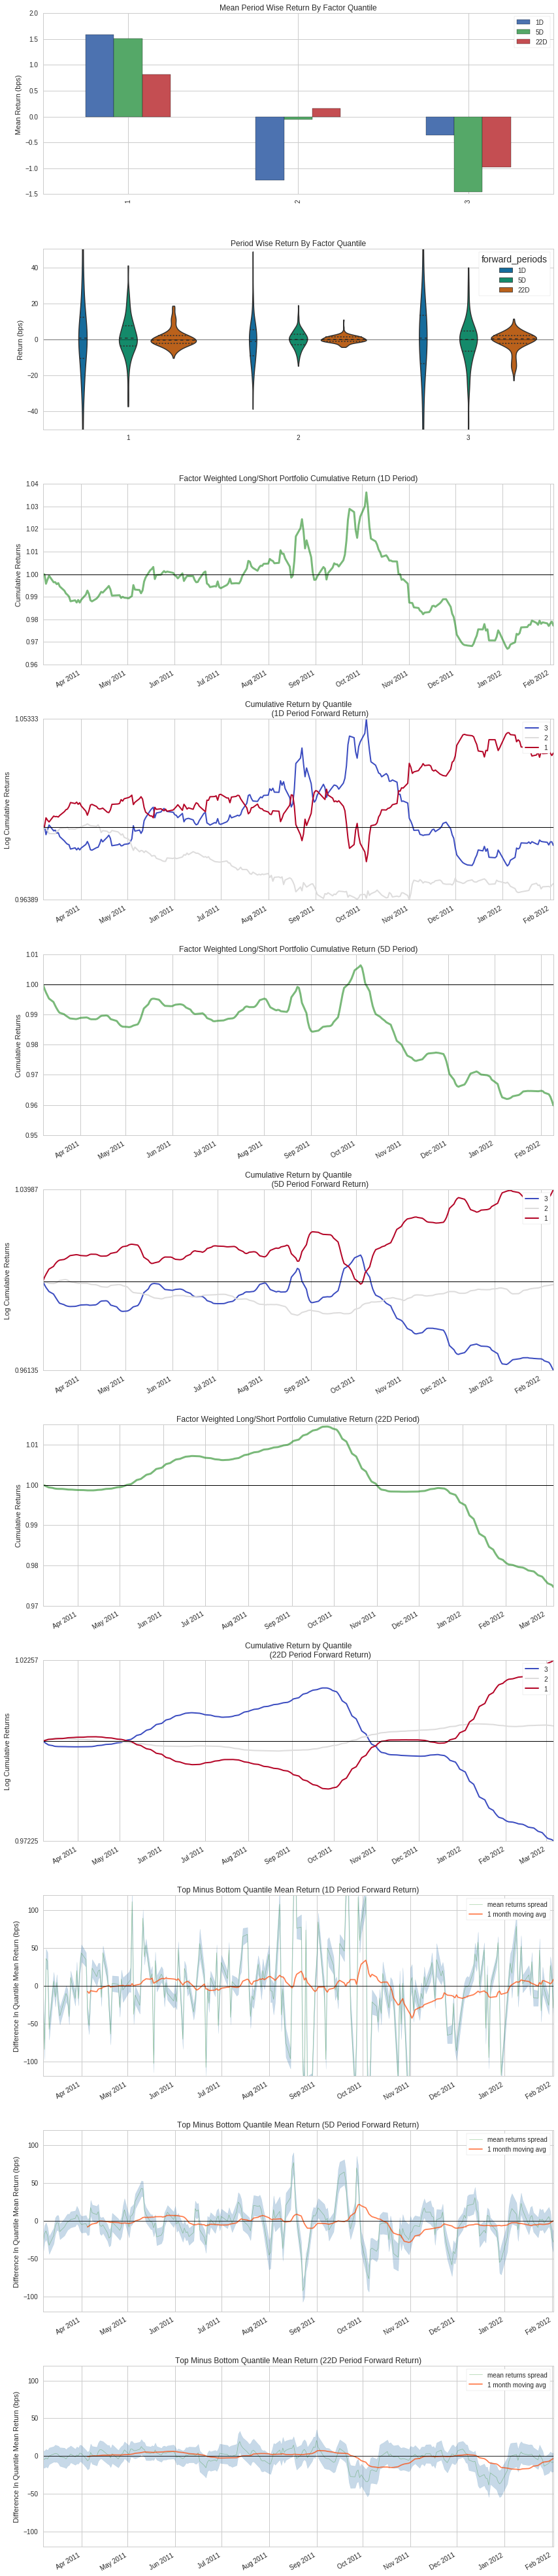

Information Analysis


,1D,5D,22D
IC Mean,0.004,-0.009,-0.009
IC Std.,0.121,0.121,0.108
Risk-Adjusted IC,0.032,-0.070,-0.087
t-stat(IC),0.492,-1.070,-1.329
p-value(IC),0.623,0.286,0.185
IC Skew,-0.167,-0.193,-0.997
IC Kurtosis,0.447,0.985,1.073


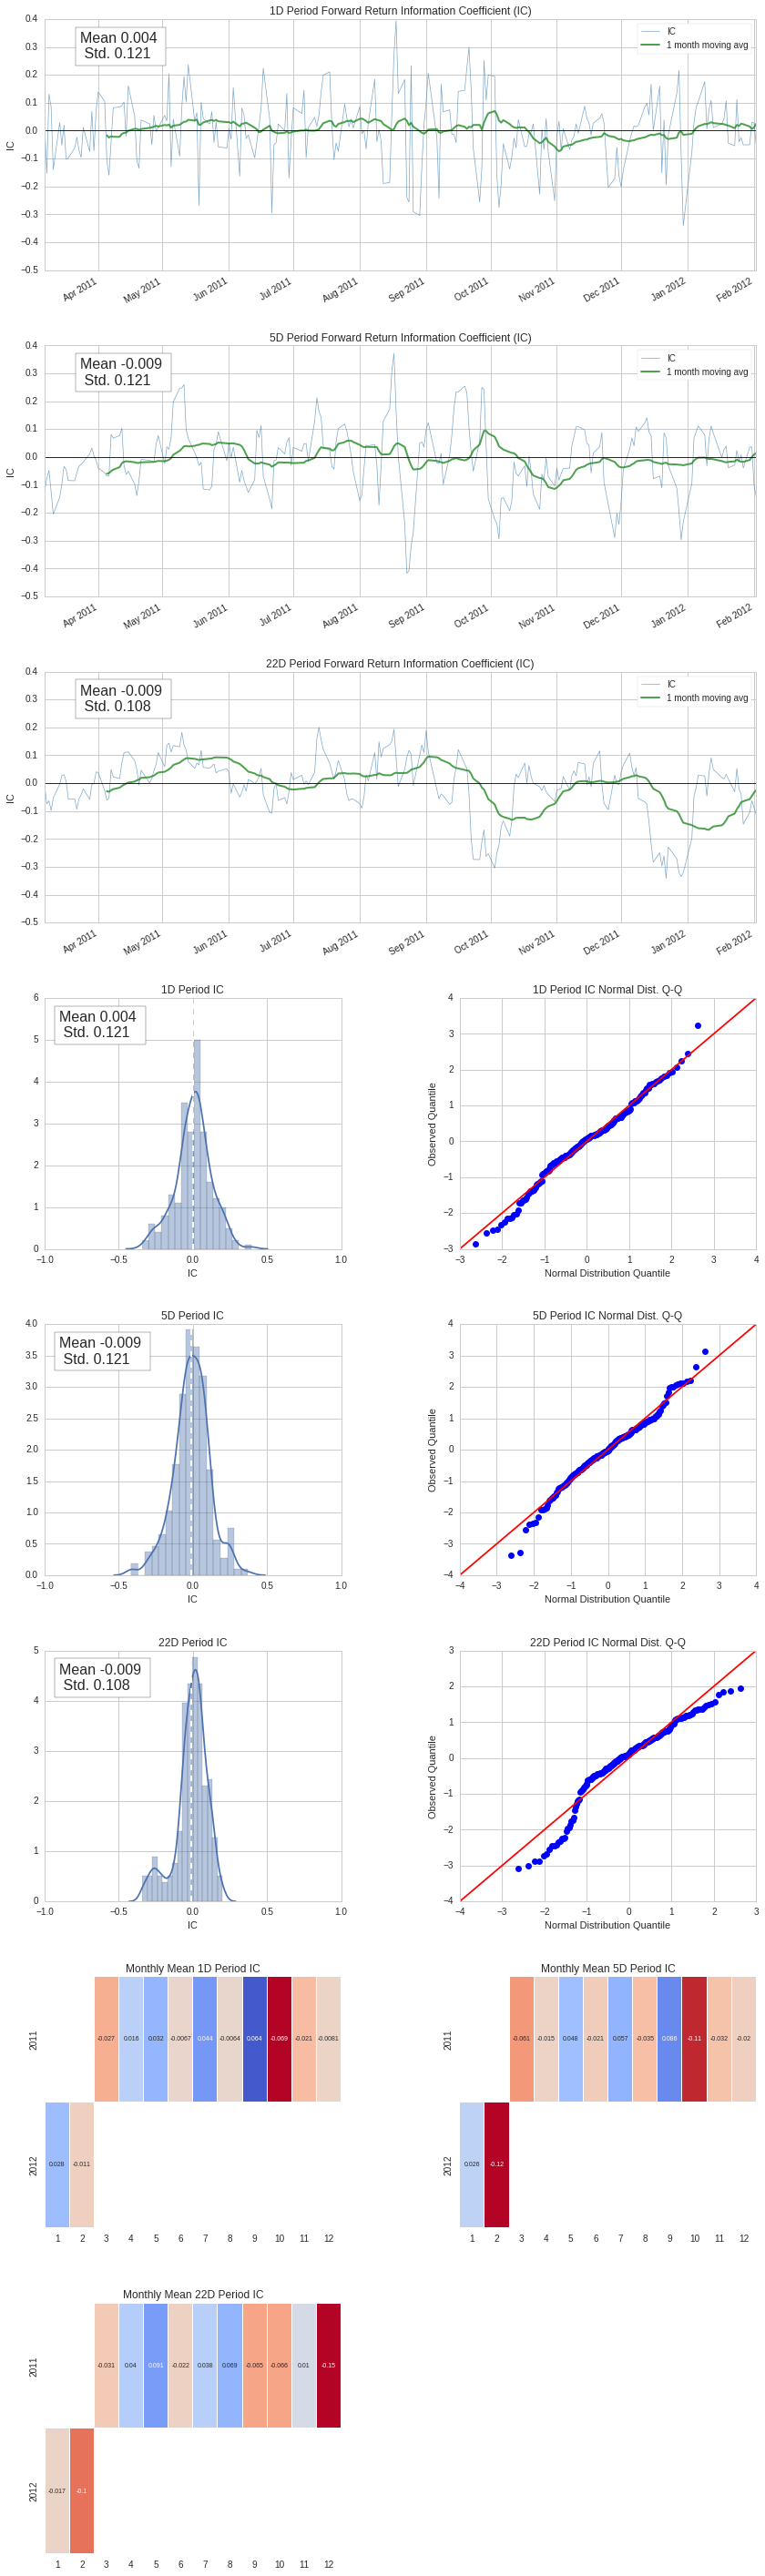

Turnover Analysis


,1D,22D,5D
Quantile 1 Mean Turnover,0.243,0.661,0.474
Quantile 2 Mean Turnover,0.432,0.666,0.624
Quantile 3 Mean Turnover,0.258,0.665,0.486


,1D,5D,22D
Mean Factor Rank Autocorrelation,0.787,0.405,0.022


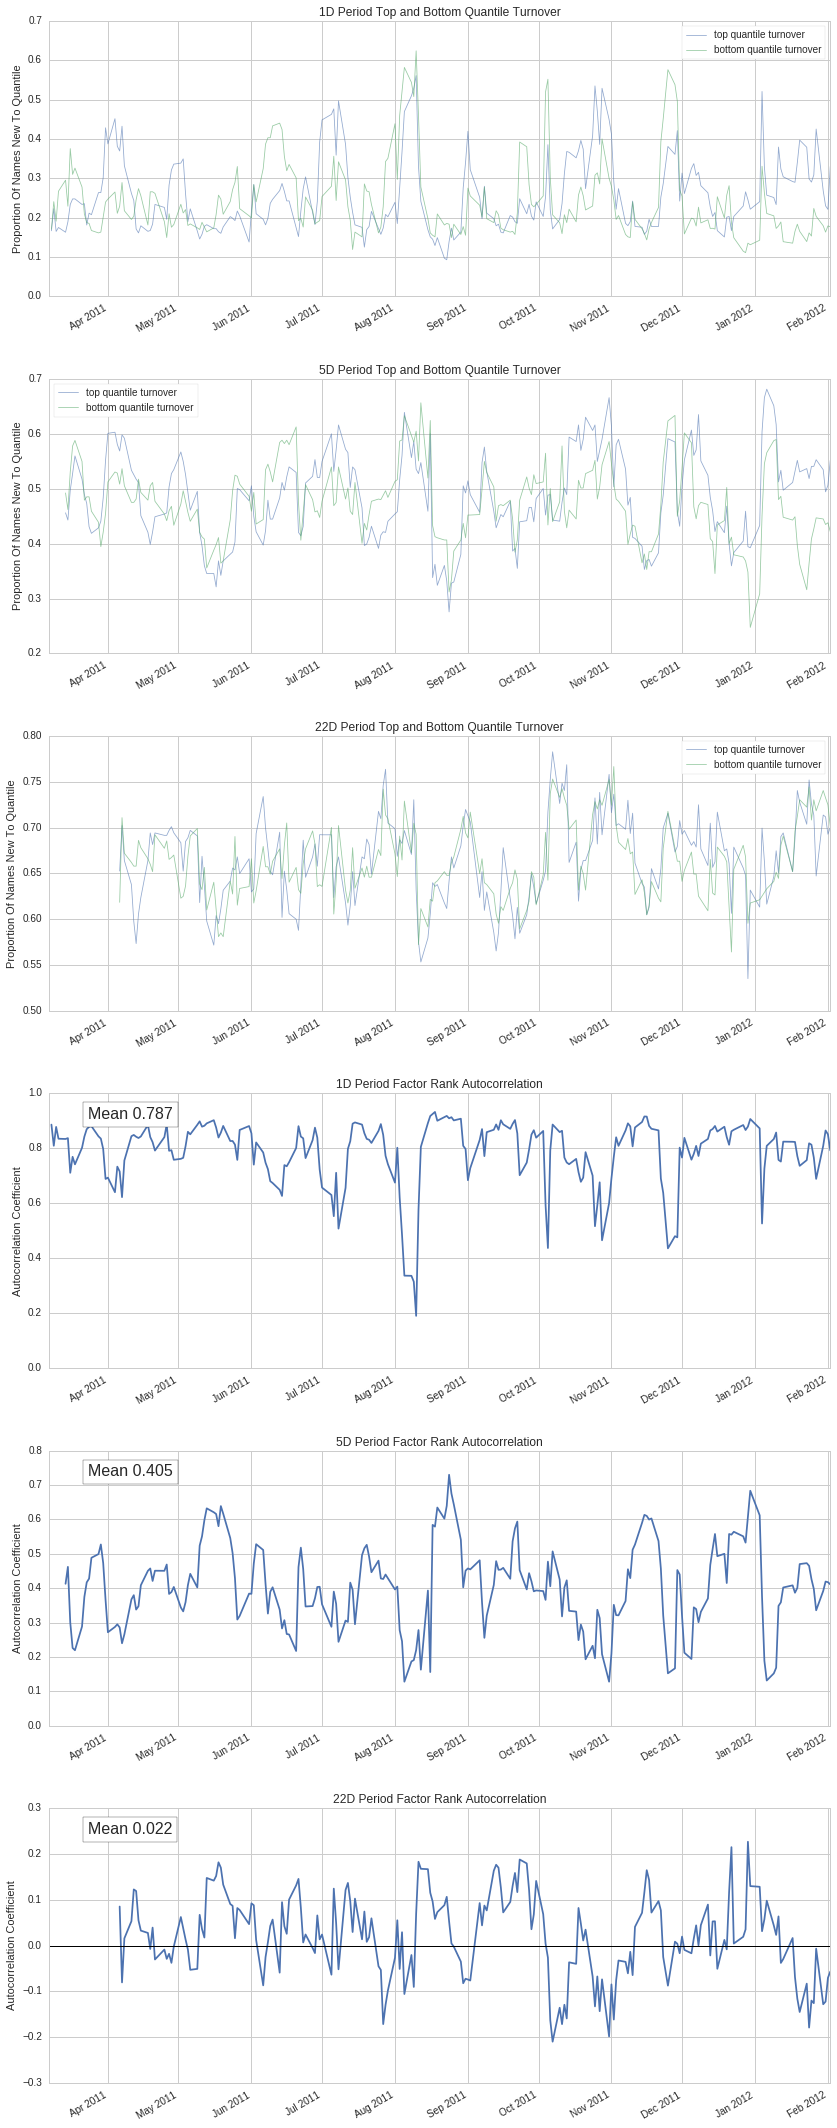

In [34]:
factor_data = alphalens.utils.get_clean_factor_and_forward_returns(factor = pipe['WILLR'],
                                                                   prices = pricing,
                                                                   quantiles=3,
                                                                   periods = (1, 5, 22))
alphalens.tears.create_full_tear_sheet(factor_data)

In [ ]:
factor_data = alphalens.utils.get_clean_factor_and_forward_returns(factor = pipe['WILLR1'],
                                                                   prices = pricing,
                                                                   quantiles=3,
                                                                   periods = (1, 5, 22))
alphalens.tears.create_full_tear_sheet(factor_data)

Dropped 9.1% entries from factor data: 9.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,1.0,505.0,250.760935,144.113352,114772,33.353288
2,497.0,1003.0,749.140302,143.732128,114631,33.312313
3,993.0,1500.0,1247.236115,143.939796,114707,33.334399


Returns Analysis


,1D,5D,22D
Ann. alpha,0.042,0.005,-0.002
beta,-0.035,-0.013,-0.018
Mean Period Wise Return Top Quantile (bps),1.832,0.025,-0.270
Mean Period Wise Return Bottom Quantile (bps),-1.422,-0.341,-0.046
Mean Period Wise Spread (bps),3.253,0.367,-0.224


In [ ]:
factor_data = alphalens.utils.get_clean_factor_and_forward_returns(factor = pipe['WILLR2'],
                                                                   prices = pricing,
                                                                   quantiles=3,
                                                                   periods = (1, 5, 22))
alphalens.tears.create_full_tear_sheet(factor_data)

In [ ]:
factor_data = alphalens.utils.get_clean_factor_and_forward_returns(factor = pipe['WILLR5'],
                                                                   prices = pricing,
                                                                   quantiles=3,
                                                                   periods = (1, 5, 22))
alphalens.tears.create_full_tear_sheet(factor_data)

In [ ]:
factor_data = alphalens.utils.get_clean_factor_and_forward_returns(factor = pipe['WILLR22'],
                                                                   prices = pricing,
                                                                   quantiles=3,
                                                                   periods = (1, 5, 22))
alphalens.tears.create_full_tear_sheet(factor_data)